In [1]:
import pandas as pd
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch import nn
from datetime import datetime
from qiskit_ibm_provider import IBMProvider
IBMProvider.save_account("5fe30e6c8e71223b5549d253025a1f141713265617a67216a3f92d3dd3ea08be71b7676a82869b7ad89d2ddcd67a117acaf2e0434f3c525b730f30bb234df6e3", overwrite=True)
provider = IBMProvider()

from QLSTM import SequenceDataset
import yfinance as yf
from pandas_datareader import data as pdr



In [2]:
df = pd.read_csv("synthetic_malaria_mutation_dataset.csv")


In [3]:
columns = ['Open', 'High', 'Low', 'Close']

In [4]:
data = df.filter(columns)
dataset = data.values

In [5]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
# Correctly split original dataframe
df_train = df.iloc[:size].copy()
df_test = df.iloc[size:].copy()

In [6]:
columns = ["mutation_label"]
target = "mutation_label"
features = columns



# Ensure we're working only with selected columns
df_train = df_train[columns]
df_test = df_test[columns]


In [7]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [8]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [9]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 1])
Target shape: torch.Size([1])


In [11]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [12]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [13]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 271


In [ ]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

In [14]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

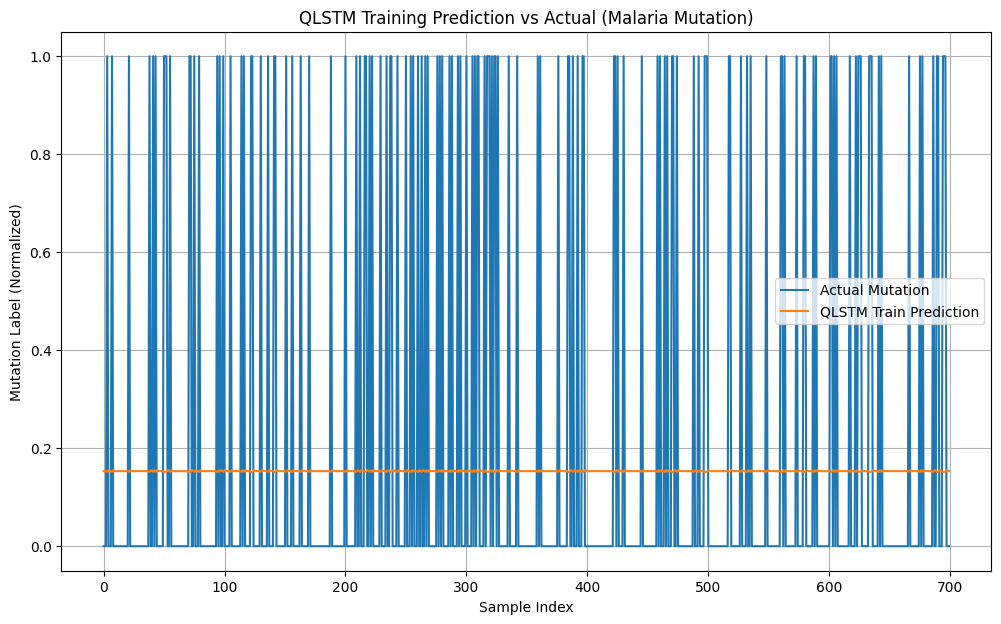

In [16]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["mutation_label"], label="Actual Mutation")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label="QLSTM Train Prediction")
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.legend()
plt.grid(True)
plt.title("QLSTM Training Prediction vs Actual (Malaria Mutation)")
plt.show()


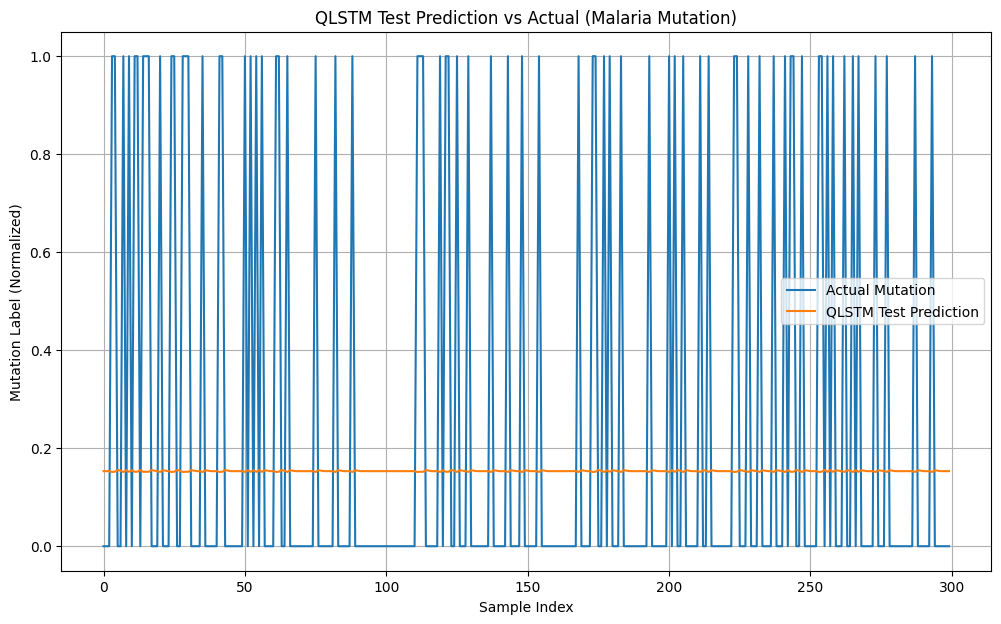

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["mutation_label"], label="Actual Mutation")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label="QLSTM Test Prediction")
plt.ylabel('Mutation Label (Normalized)')
plt.xlabel('Sample Index')
plt.title("QLSTM Test Prediction vs Actual (Malaria Mutation)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
from sklearn.metrics import mean_squared_error
import math

train_rmse = math.sqrt(mean_squared_error(df_train["mutation_label"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["mutation_label"], df_test["Model Forecast"]))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.39727108140857015
Test RMSE: 0.4366515582021815


In [22]:
import numpy as np  # Make sure this is included if not already

# Accuracy function with ±0.1 tolerance
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

# Use correct column name for mutation data
train_accuracy = accuracy(df_train["mutation_label"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["mutation_label"], df_test["Model Forecast"])

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Train accuracy: 0.0000
Test accuracy: 0.0000


In [23]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")

In [24]:
import json
import numpy as np

# Example: Assume predicted values are in a numpy array
predicted_values = np.array([1.23, 4.56, 7.89])  # This is just a placeholder for your actual predicted values

# Save the predicted values to a JSON file
with open('prediction.json', 'w') as f:
    json.dump(predicted_values.tolist(), f)
